In this notebook we will create the graph analysis for each of the agent's mode and traffic profiles per slice.

In [81]:
import sys
sys.path.insert(0, '../')

# # Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ast
from graphviz import Digraph
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

# Import Constatns
from script.experiments_constants import AGENT_EXPERIMENT_INFO
from script.experiments_constants import ENV_KPI_NAME_LIST

from constants import proj_address

from script.load_data import handle_data
from script.symbolic_representation import create_symbolic_state_decision_matrix

# Load and Show some results for each one of the agents

In this part we will load the data of one of the agents and visualize some of the numerical data.

## Graph Plotter Function Code

In [82]:
# Choose one of the agents: 'embb-trf1', 'embb-trf2', 'urllc-trf1', 'urllc-trf2'
agent = 'urllc-trf1'

# Choose one of the users: 3, 4, 5, 6 - Combination of agent and user will determine a specific experiment
user = 3

# Assuming AGENT_EXPERIMENT_INFO, handle_data and create_symbolic_state_decision_matrix are defined elsewhere in your codebase
agent_info = AGENT_EXPERIMENT_INFO[agent]
kpi_data, decision_data = handle_data(agent_info, user)
symbolic_df, marker_df = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, user)
symbolic_df['combined_decision'] = symbolic_df.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)

print(f"Agent: {agent} - Users: {user}")
print("")

Agent: urllc-trf1 - Users: 3



## Graph Plotter Util

In [83]:
def plot_graph_from_data(df, column_name, output_path, node_threshold=0, edge_threshold=0, title_suffix=''):
    cross_data = pd.crosstab(df[column_name], df[column_name].shift(-1), normalize='index') * 100
    decision_counts = df[column_name].value_counts(normalize=True)
    
    # Filter nodes based on node_threshold
    filtered_nodes = decision_counts[decision_counts >= node_threshold].index
    
    # Filter edges based on edge_threshold and filtered nodes
    filtered_cross_data = cross_data.loc[filtered_nodes, filtered_nodes]
    for i, row in filtered_cross_data.iterrows():
        filtered_cross_data.loc[i] = row[row >= edge_threshold * 100]
    
    # Normalize the filtered cross data to ensure the probabilities sum to 1
    filtered_cross_data = filtered_cross_data.div(filtered_cross_data.sum(axis=1), axis=0).fillna(0) * 100
    
    dot = Digraph(comment='Decision Graph', engine='dot')
    
    num_nodes = len(filtered_nodes)
    num_edges = len(filtered_cross_data.columns)
    
    # Set the size of the graph based on the number of nodes and edges
    width = max(12, num_nodes * 2)
    height = max(8, num_edges)
    dot.attr(rankdir='LR', size=f'{width},{height}', dpi='120', bgcolor='white')
    
    # Add nodes
    for node, freq in decision_counts.items():
        if node in filtered_nodes:
            node_size = 1 + 2 * freq  # Moderate size difference
            label = node.split(' - ')
            label.append(f'prob: {freq:.1%}')
            label = '\n'.join(label)
            dot.node(node, label, shape='ellipse', 
                     width=str(node_size), height=str(node_size),
                     style='filled', fillcolor='#E6F3FF', color='#4A6FE3',
                     fontname='Arial', fontsize='10')
    
    # Add edges
    for i, row in filtered_cross_data.iterrows():
        for j, prob in row.items():
            if prob > 0:
                penwidth = 0.5 + prob / 50  # Reduced edge width scaling
                dot.edge(i, j, 
                         label=f'{prob:.1f}%', 
                         penwidth=str(penwidth),
                         color='#4A6FE3',
                         fontname='Arial', fontsize='8',
                         fontcolor='#4A6FE3')
    
    # Add legend with title suffix
    dot.attr(label=f'Node size: state frequency | Edge width: transition probability | {title_suffix}', 
             fontname='Arial', fontsize='12', labelloc='t')
    
    # Save the graph as a PDF
    dot.render(output_path, format='pdf', cleanup=True)
    
    return dot

## Create Graphs

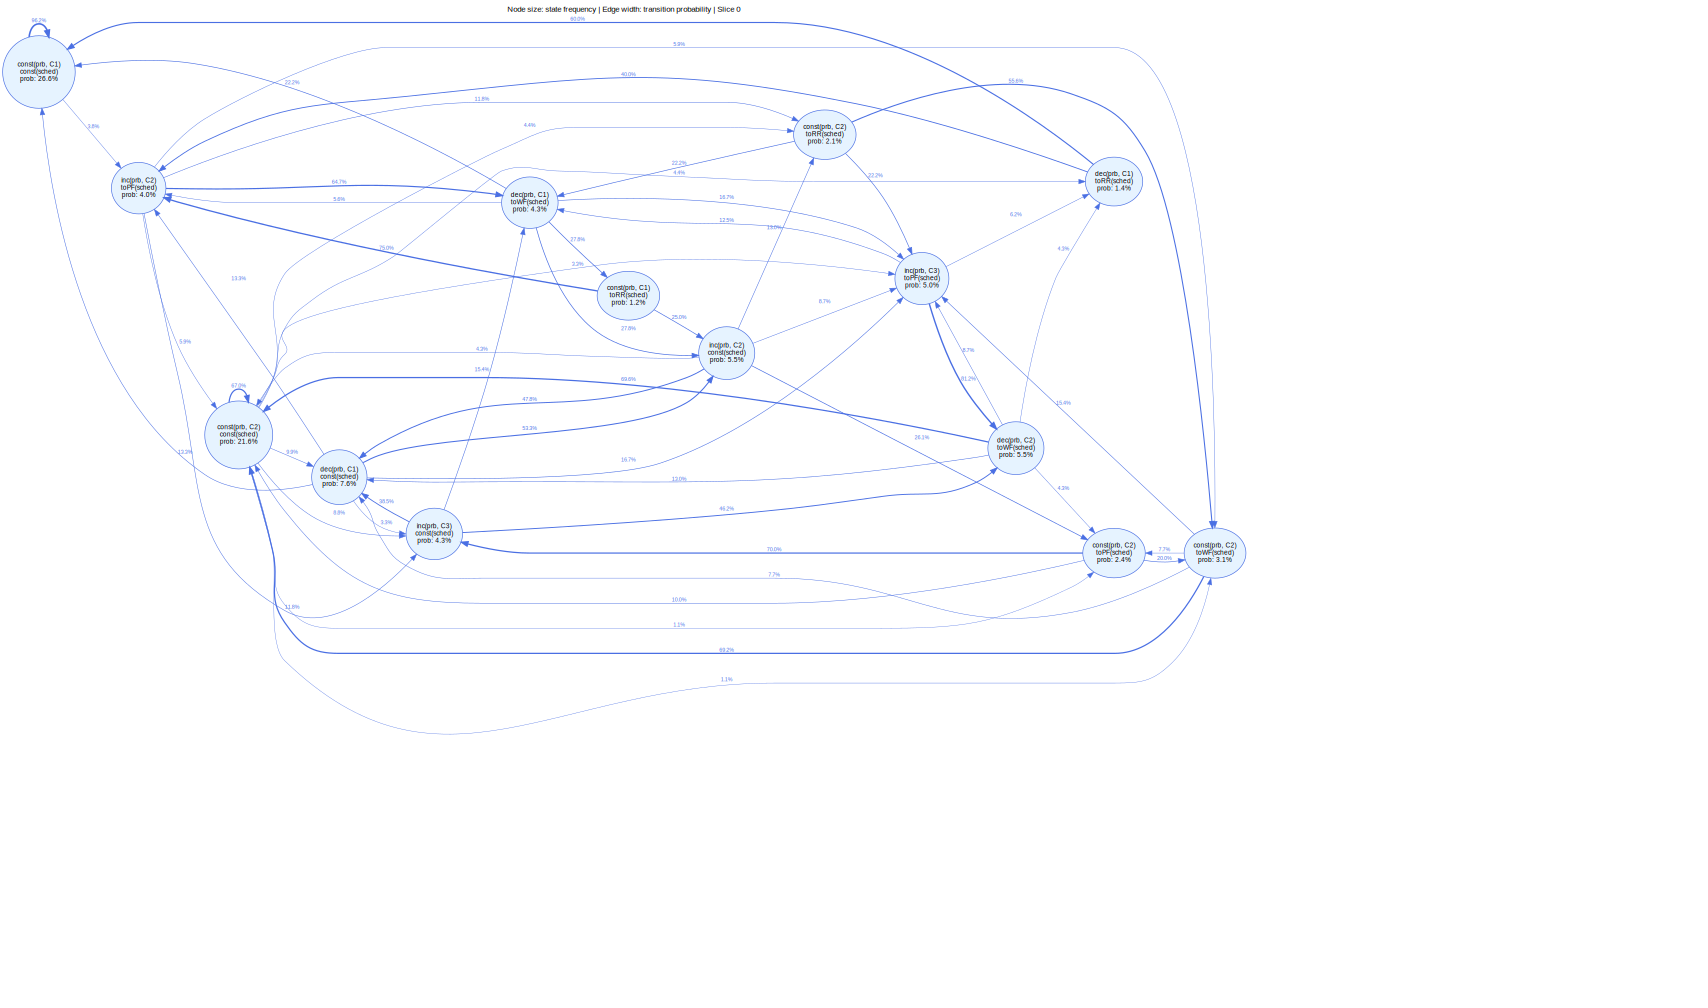

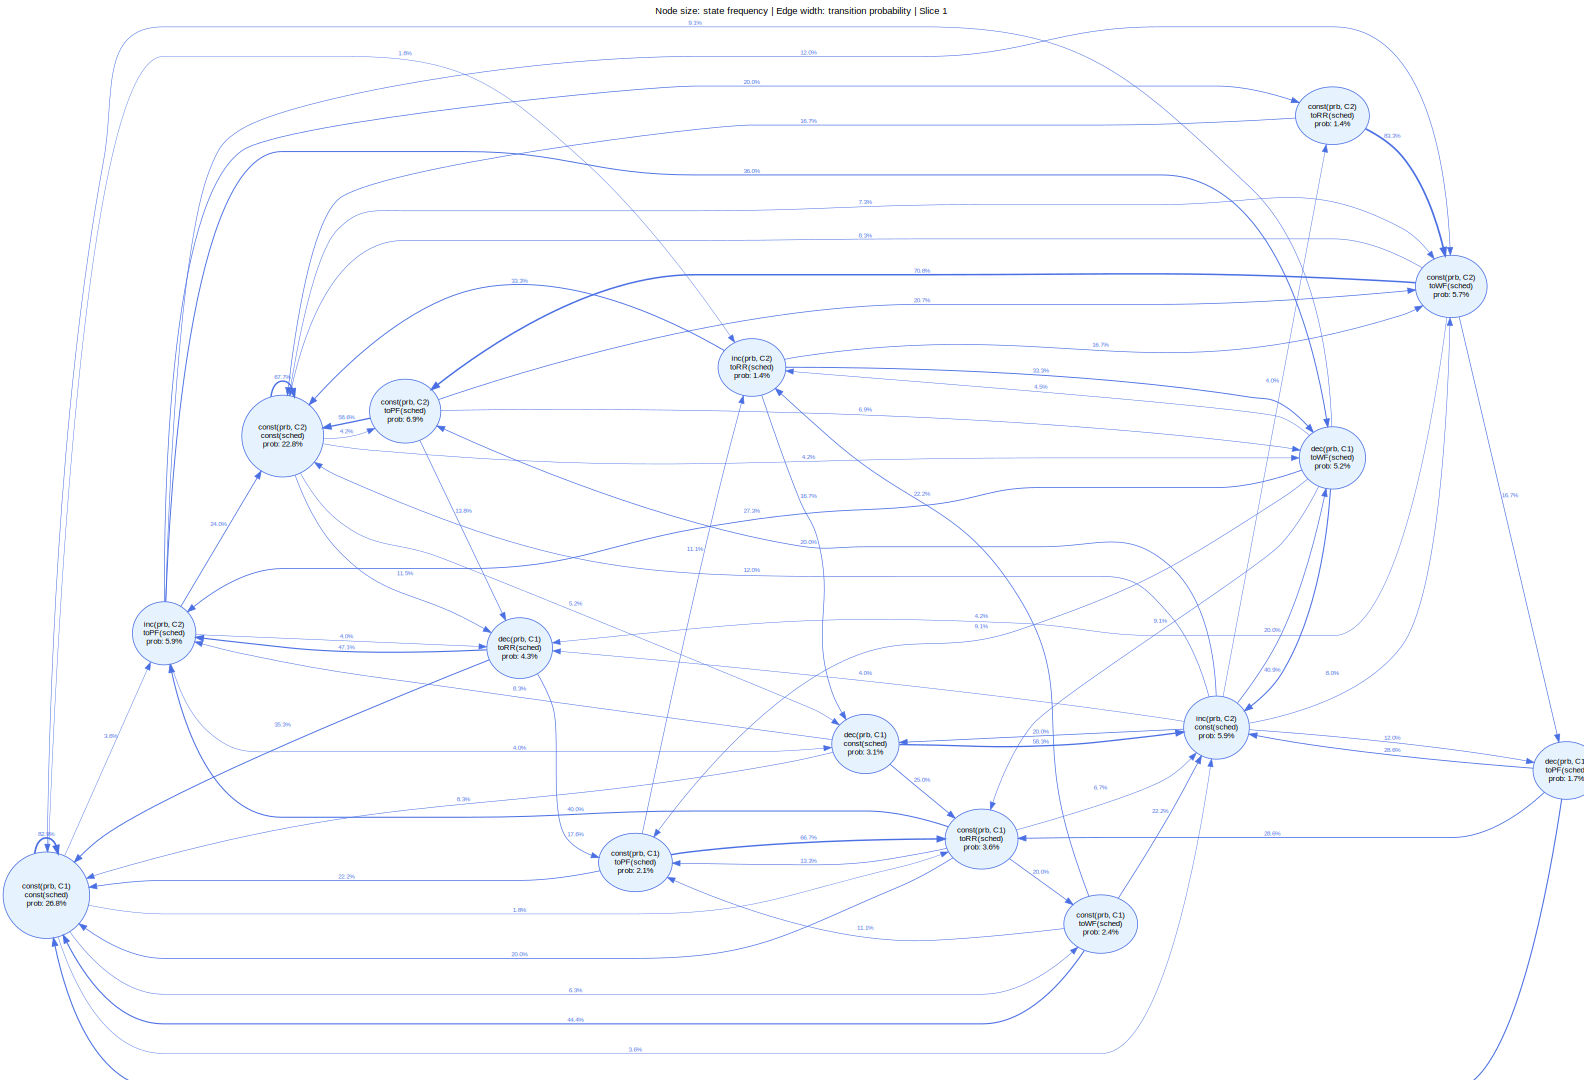

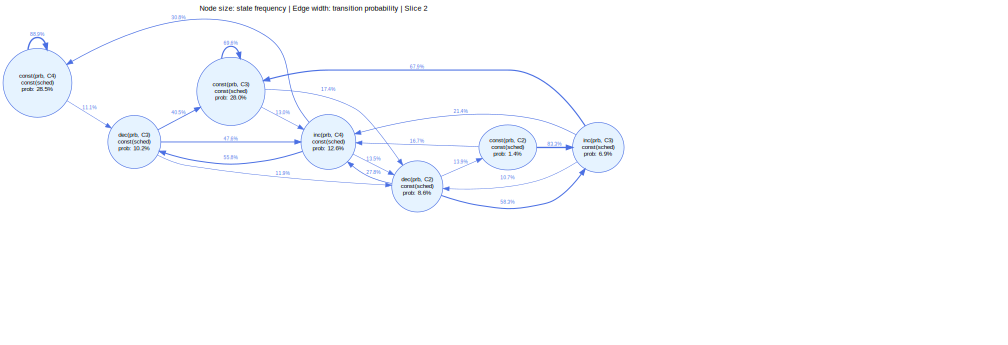

Decision graphs have been generated, saved as PDFs, and displayed inline.


In [84]:
# Plot the graph for each slice, display in the notebook, and save as PDF
slices = [0, 1, 2]
output_dir = f"{proj_address}/A1-NetworkSlicingSchedulingPolicy/results/decision_graphs/{agent}-users{user}"  # Specify the directory to save the graphs

for slice_id in slices:
    # Filter the data for the current slice
    slice_data = symbolic_df[symbolic_df['slice_id'] == slice_id].copy()
    
    # Generate the graph with a title suffix indicating the slice number
    title_suffix = f'Slice {slice_id}'
    output_path = f"{output_dir}/Decision_Graph_{agent}_user-{user}_slice-{slice_id}"
    
    dot = plot_graph_from_data(slice_data, 'combined_decision', output_path, node_threshold=0.01, edge_threshold=0.01, title_suffix=title_suffix)
    
    # Display the graph inline
    display(dot)

print("Decision graphs have been generated, saved as PDFs, and displayed inline.")